## Notebook to compare the different flux limits in ldust and radio

In [1]:
import numpy as np
from numpy import trapz
import pandas as pd
import random
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit as curve_fit
from scipy.stats import norm,binned_statistic
import scipy.integrate as integrate
from scipy.stats import norm
from astropy.io import ascii, fits
from astropy import wcs
from pymoc.util.catalog import catalog_to_moc
from scipy.stats import norm,kstest

from astropy.stats import bootstrap
from astropy.table import Table,vstack,Column,join
from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u
from astropy.coordinates import SkyCoord,match_coordinates_sky


from matplotlib.colors import LogNorm
from lifelines import KaplanMeierFitter
from herschelhelp import image_plotting
from herschelhelp_internal.utils import inMoc,flux_to_mag
import pymoc
from pymoc.io.fits import read_moc_fits

from astropy.io import registry
from astropy.table.info import serialize_method_as
import statsmodels.duration.survfunc as survfunc

In [30]:
def get_center(bins):
    centers = (bins[:-1] + bins[1:])/2
    return(centers)

In [32]:
def power_law(x,N,a):
    y = N * (1+x)**a
    return(y)

In [2]:
lofar_sed_en1 = Table.read('data/lofar_sed_en1.fits')
print(len(lofar_sed_en1))
lofar_sed_en1[0]

31602


Source_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Isl_rms,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,ID,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,ID_OPTICAL,ID_SPITZER,FLAG_OVERLAP,u_flux_corr,u_fluxerr_corr,u_mag_corr,u_magerr_corr,g_flux_corr,g_fluxerr_corr,g_mag_corr,g_magerr_corr,r_flux_corr,r_fluxerr_corr,r_mag_corr,r_magerr_corr,i_flux_corr,i_fluxerr_corr,i_mag_corr,i_magerr_corr,z_flux_corr,z_fluxerr_corr,z_mag_corr,z_magerr_corr,y_flux_corr,y_fluxerr_corr,y_mag_corr,y_magerr_corr,g_hsc_flux_corr,g_hsc_fluxerr_corr,g_hsc_mag_corr,g_hsc_magerr_corr,r_hsc_flux_corr,r_hsc_fluxerr_corr,r_hsc_mag_corr,r_hsc_magerr_corr,i_hsc_flux_corr,i_hsc_fluxerr_corr,i_hsc_mag_corr,i_hsc_magerr_corr,z_hsc_flux_corr,z_hsc_fluxerr_corr,z_hsc_mag_corr,z_hsc_magerr_corr,y_hsc_flux_corr,y_hsc_fluxerr_corr,y_hsc_mag_corr,y_hsc_magerr_corr,nb921_hsc_flux_corr,nb921_hsc_fluxerr_corr,nb921_hsc_mag_corr,nb921_hsc_magerr_corr,J_flux_corr,J_fluxerr_corr,J_mag_corr,J_magerr_corr,K_flux_corr,K_fluxerr_corr,K_mag_corr,K_magerr_corr,ch1_swire_flux_corr,ch1_swire_fluxerr_corr,ch1_swire_mag_corr,ch1_swire_magerr_corr,ch2_swire_flux_corr,ch2_swire_fluxerr_corr,ch2_swire_mag_corr,ch2_swire_magerr_corr,ch3_swire_flux_corr,ch3_swire_fluxerr_corr,ch3_swire_mag_corr,ch3_swire_magerr_corr,ch4_swire_flux_corr,ch4_swire_fluxerr_corr,ch4_swire_mag_corr,ch4_swire_magerr_corr,ch1_servs_flux_corr,ch1_servs_fluxerr_corr,ch1_servs_mag_corr,ch1_servs_magerr_corr,ch2_servs_flux_corr,ch2_servs_fluxerr_corr,ch2_servs_mag_corr,ch2_servs_magerr_corr,Separation,help_id,RA_HELP,DEC_HELP,EBV,CLASS_STAR,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_corr_err_g,tot_corr_r,tot_corr_err_r,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest,Ldust_best,Ldust_sigma,Ldust_bayes,Ldust_03,Ldust_16,Ldust_50,Ldust_84,Ldust_98,SFR_bayes,chi2,chi2_99_flag,LIR_8_1000_med,LIR_8_1000_p16,LIR_8_1000_p84,LIR_8_1000_ml,LIR,LIR_em,LIR_ep,logL150,goodAF,ln_l,q150,radio_luminosity,q_magphys,q_agnfitter,q_250,q_350,q_500,kcorr_250,kcorr_350,kcorr_500,Radio_ID,Spitzer_SN,Donley,Lacy,Stern,Messias,KI,Ch2_Ch4,Ch4_24mu,Xray,Opt_spec,AGNfrac_af,AGNfrac_af_16,AGNfrac_cg_s,AGNfrac_cg_s_16,AGNfrac_cg_f,AGNfrac_cg_f_16,Chi_sq_MpBp,Chi_sq_AfCg,AGN_final,Mass_conc,SFR_conc,Radio_excess,Radio_excess_DJS,Extended_radio,RadioAGN_final
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [3]:
lofar_magphys_en1 = Table.read('data/magphys_mass_radio_limits_en1.fits')
#mask = lofar_magphys_en1['q_lim']==1E20
#lofar_magphys_en1['q_lim'][mask] = np.nan
print(len(lofar_magphys_en1))
lofar_magphys_en1[0]

146996


ID,z,chi2,chi2_99_flag,fmu_sfh_best,fmu_sfh_sigma,fmu_sfh_bayes,fmu_sfh_03,fmu_sfh_16,fmu_sfh_50,fmu_sfh_84,fmu_sfh_98,fmu_IR_best,fmu_IR_sigma,fmu_IR_bayes,fmu_IR_3,fmu_IR_16,fmu_IR_50,fmu_IR_86,fmu_IR_98,mu_best,mu_sigma,mu_bayes,mu_03,mu_16,mu_50,mu_84,mu_98,tau_V_best,tau_V_sigma,tau_V_bayes,tau_V_03,tau_V_16,tau_V_50,tau_V_84,tau_V_98,sSFR_best,sSFR_sigma,sSFR_bayes,sSFR_03,sSFR_16,sSFR_50,sSFR_84,sSFR_98,Mstar_best,Mstar_sigma,Mstar_bayes,Mstar_03,Mstar_16,Mstar_50,Mstar_84,Mstar_98,Ldust_best,Ldust_sigma,Ldust_bayes,Ldust_03,Ldust_16,Ldust_50,Ldust_84,Ldust_98,TC_ISM_best,TC_ISM_sigma,TC_ISM_bayes,TC_ISM_03,TC_ISM_16,TC_ISM_50,TC_ISM_84,TC_ISM_98,TW_BC_best,TW_BC_sigma,TW_BC_bayes,TW_BC_03,TW_BC_16,TW_BC_50,TW_BC_84,TW_BC_98,xi_C_tot_best,xi_C_tot_sigma,xi_C_tot_bayes,xi_C_tot_03,xi_C_tot_16,xi_C_tot_50,xi_C_tot_84,xi_C_tot_98,xi_PAH_tot_best,xi_PAH_tot_sigma,xi_PAH_tot_bayes,xi_PAH_tot_03,xi_PAH_tot_16,xi_PAH_tot_50,xi_PAH_tot_84,xi_PAH_tot_98,xi_MIR_tot_best,xi_MIR_tot_sigma,xi_MIR_tot_bayes,xi_MIR_tot_03,xi_MIR_tot_16,xi_MIR_tot_50,xi_MIR_tot_84,xi_MIR_tot_98,xi_W_tot_best,xi_W_tot_sigma,xi_W_tot_bayes,xi_W_tot_03,xi_W_tot_16,xi_W_tot_50,xi_W_tot_84,xi_W_tot_98,tau_V_ISM_best,tau_V_ISM_sigma,tau_V_ISM_bayes,tau_V_ISM_03,tau_V_ISM_16,tau_V_ISM_50,tau_V_ISM_84,tau_V_ISM_98,Mdust_best,Mdust_sigma,Mdust_bayes,Mdust_03,Mdust_16,Mdust_50,Mdust_84,Mdust_98,SFR_best,SFR_sigma,SFR_bayes,SFR_03,SFR_16,SFR_50,SFR_84,SFR_98,ID_OPTICAL,ID_SPITZER,RA,DEC,help_id,RA_HELP,DEC_HELP,EBV,CLASS_STAR,FLAG_OVERLAP,FLAG_CLEAN,u_flux,u_fluxerr,g_flux,g_fluxerr,r_flux,r_fluxerr,i_flux,i_fluxerr,z_flux,z_fluxerr,y_flux,y_fluxerr,g_hsc_flux,g_hsc_fluxerr,r_hsc_flux,r_hsc_fluxerr,i_hsc_flux,i_hsc_fluxerr,z_hsc_flux,z_hsc_fluxerr,y_hsc_flux,y_hsc_fluxerr,nb921_hsc_flux,nb921_hsc_fluxerr,J_flux,J_fluxerr,K_flux,K_fluxerr,ch1_servs_flux,ch1_servs_fluxerr,ch2_servs_flux,ch2_servs_fluxerr,ch1_swire_flux,ch1_swire_fluxerr,ch2_swire_flux,ch2_swire_fluxerr,ch3_swire_flux,ch3_swire_fluxerr,ch4_swire_flux,ch4_swire_fluxerr,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_corr_err_g,tot_corr_r,tot_corr_err_r,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest,radio_flux_pixel,radio_flux_limit,radio_luminosity_pixel,radio_luminosity_limit,q_pixel,q_lim,q_250_lim,q_350_lim,q_500_lim,kcorr_250,kcorr_350,kcorr_500
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,deg,deg,,,,,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,,,,,,,,,,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,solMass,solMass,solMass,solMass / yr,solMass 

In [5]:
#create a mask to select a sample that is complete in stellar mass and redshift
#for a mass complete sample at z<1.0 Mstar>10.7
mask_loc = (lofar_sed_en1['RA']>242.5) & (lofar_sed_en1['RA']<243.5) & (lofar_sed_en1['DEC']>54) & (lofar_sed_en1['DEC']<56) 
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<1.0) & (lofar_sed_en1['Mass_median']>10.7)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - lofar_sed_en1['Mass_median'] - np.log10(3.8*10**26))>-10.5
detected_sample_en1 = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_sample_en1)))



'''mask_loc = (lofar_magphys_en1['RA']>242.5) & (lofar_magphys_en1['RA']<243.5) & (lofar_magphys_en1['DEC']>54) & (lofar_magphys_en1['DEC']<56)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<1.0) & (lofar_magphys_en1['Mass_median']>10.7)# & mask_loc
SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - lofar_magphys_en1['Mass_median'])>-10.5
limit_sample_en1 = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_sample_en1)))'''

There are 3935 galaxies detected in the radio with a stellar mass>10.7 and z<1


"mask_loc = (lofar_magphys_en1['RA']>242.5) & (lofar_magphys_en1['RA']<243.5) & (lofar_magphys_en1['DEC']>54) & (lofar_magphys_en1['DEC']<56)\nmask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<1.0) & (lofar_magphys_en1['Mass_median']>10.7)# & mask_loc\nSSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - lofar_magphys_en1['Mass_median'])>-10.5\nlimit_sample_en1 = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]\nprint('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_sample_en1)))"

In [26]:
def plot_depth(catalogue):
    x = np.log10(catalogue['Total_flux'])
    y = catalogue['Ldust_bayes']
    z = catalogue['Z_BEST']
    dist = cosmo.luminosity_distance(z).to(u.m).value
    y = np.log10(y/( 4*np.pi * dist**2))
    
    plt.scatter(x,y,s=5,alpha=0.1,c='red',label='total flux')
    
    x = np.log10(catalogue['Peak_flux'])
    plt.scatter(x,y,s=5,alpha=0.05,c='blue',label='peak flux')
    plt.xlabel('150MHz flux')
    plt.ylabel('ldust flux')
    plt.legend()
    plt.ylim(-17,-14)
    plt.xlim(-4.5,-2)
    plt.show()

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


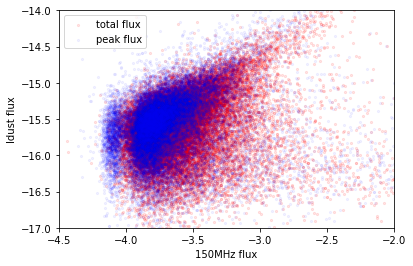

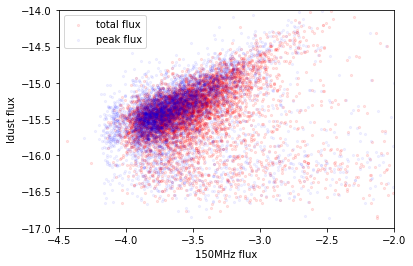

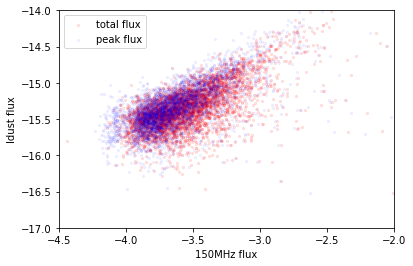

In [27]:
plot_depth(lofar_sed_en1)
plot_depth(lofar_sed_en1[mask_mass_complete_en1])
plot_depth(lofar_sed_en1[mask_mass_complete_en1 & SSFR_mask])

There are 1692 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 1312 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1
[10.1990494  10.24555721 10.29288616 10.3393013  10.39669399 10.45034599
 10.51720772 10.5968338  10.68884029 10.82979259 11.50807722]
power law fit parameters: alpha = -0.15186 +\- 0.0089498, N = 2.0783 +\- 0.0097732
There are 1748 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 1692 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 1191 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1
[10.1990494  10.24817152 10.2981123  10.35047665 10.40339241 10.45986509
 10.52529793 10.60660963 10.6977354  10.83534222 11.50807722]
power law fit parameters: alpha = -0.15978 +\- 0.015467, N = 2.0794 +\- 0.010298
There are 1748 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 1680 galaxies detected in the radio with a stellar mass>10.7 and z

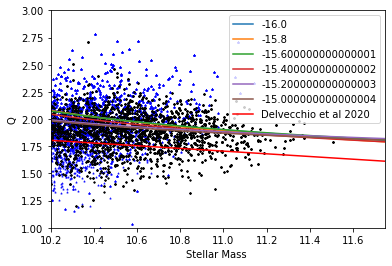

In [40]:
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

#create a mask to select a sample that is complete in stellar mass and redshift
#for a mass complete sample at z<1.0 Mstar>10.7

z = lofar_sed_en1['Z_BEST']
dist = cosmo.luminosity_distance(z).to(u.m).value
ldust_flux = np.log10(lofar_sed_en1['Ldust_bayes']/(4*np.pi*dist*dist))

z = lofar_magphys_en1['Z_BEST']
dist = cosmo.luminosity_distance(z).to(u.m).value
ldust_flux_lims = np.log10(lofar_magphys_en1['Ldust_bayes']/(4*np.pi*dist*dist))

ldust_lims = np.arange(-16,-14.8,0.2)
for lim in ldust_lims:
    mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<0.4) & (lofar_sed_en1['Mass_median']>10.2)# & mask_loc
    agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
    SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - lofar_sed_en1['Mass_median'] - np.log10(3.8*10**26))>-10.5
    ldust_mask = ldust_flux>lim
    detected_data = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask & ldust_mask]
    print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_data)))



    mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<0.4) & (lofar_magphys_en1['Mass_median']>10.2)# & mask_loc
    SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - lofar_magphys_en1['Mass_median']) > -10.5
    ldust_mask = ldust_flux_lims>lim
    limit_data = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask & ldust_mask]
    print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_data)))


    mask = (~np.isnan(detected_data[det_name])) & (~np.isinf(detected_data[det_name]))
    detected_data = detected_data[mask]

    mask = (~np.isnan(limit_data[lim_name])) & (~np.isinf(limit_data[lim_name]))
    limit_data = limit_data[mask]




    x = limit_data['Mass_median']
    y = limit_data[lim_name]
    plt.scatter(x,y,s=1,marker='^',c='blue')

    x = detected_data['Mass_median']
    y = detected_data[det_name]
    plt.scatter(x,y,s=1,c='black')




    redshifts = np.append(detected_data['Mass_median'],limit_data['Mass_median'])
    bins_z = []
    percentiles = np.linspace(0,100,11).astype(int)
    for n,percent in enumerate(percentiles):
        bins_z.append(np.percentile(redshifts,percent))
    bins_z = np.array(bins_z)
    bins_z[0] = bins_z[0] - 0.001
    bins_z[-1] = bins_z[-1] + 0.001
    print(bins_z)


    num = 10
    N = int(len(detected_data)*0.9)
    bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
    N = int(len(limit_data)*0.9)
    bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

    median_q = []
    kmfs = []
    popts = []
    pcovs = []
    for n in range(num):
        data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
        #data[flag_detected] = q_lim[flag_detected]
        det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))

        redshift_det = detected_data['Mass_median'][bootstrap_det[n]]
        ldust_det = detected_data[ldust_name][bootstrap_det[n]]

        redshift_lim = limit_data['Mass_median'][bootstrap_lim[n]]
        ldust_lim = limit_data[ldust_name][bootstrap_lim[n]]

        kmf = KaplanMeierFitter() 

        ## Fit the data into the model
        kmf.fit(data, det,label='Kaplan Meier Estimate')

        kmfs.append(kmf)


        redshifts = np.append(redshift_det,redshift_lim)



        test = np.digitize(redshifts,bins=bins_z)
        nums_z,counts = np.unique(test,return_counts=True)

        ras_binned = []
        decs_binned = []
        redshift_binned = []
        mean_q_agnfitter = []
        median_q_err = []
        #there is an error is a source has a stellar mass equal to the right hand side of the final mass bin
        #if this happens then they are put into their own seperate bin so you end up with more nums than there are bins
        #This causes an error when it comes to plotting them. To solve this i only look at the first ten bins
        for n,num in enumerate(nums_z[:len(bins_z)-1]):
            mask = (test==num) #& (redshift_all<np.max(redshift))
            q_vals = data[mask]
            q_det = det[mask]
            q_lims = data[mask][~det[mask].astype(bool)]

            redshift_binned.append(redshifts[mask])



            kmf = KaplanMeierFitter()
            kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')

            if n==20:
                bins = np.arange(-3,4,0.1)
                fig,ax1 = plt.subplots()

                ax1.hist(q_vals[q_det.astype(bool)],label='detections',bins=bins,histtype='step',color='black')
                ax1.hist(q_vals[~q_det.astype(bool)],label='lower limit',bins=bins,histtype='step',color='blue')

                ax2 = ax1.twinx()
                x = kmf.cumulative_density_['Kaplan Meier Estimate'].index
                y = kmf.cumulative_density_['Kaplan Meier Estimate'].values
                ax2.plot(x,y)
                lowx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
                upx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
                ax2.fill_between(x,lowx,upx,alpha=0.3)
                ax2.set_ylabel('CDF')

                plt.vlines(kmf.median_survival_time_,0,2000)
                plt.ylim(0,1.1)
                plt.xlim(-0.5,3)
                ax1.set_xlabel('q')
                ax1.set_ylabel('N')
                ax1.legend(loc='upper left')
                plt.show()

            x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
            x = np.arange(-1,3,0.01)

            lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
            lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
            upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
            upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

            err = upx-lowx

            mean_q_agnfitter.append(kmf.median_)
            median_q_err.append(err)

        x = get_center(bins_z)
        y = np.array(mean_q_agnfitter)
        yerr = np.array(median_q_err)
        mask = (~np.isinf(y)) & (~np.isnan(y))
        popt,pcov = curve_fit(power_law,x[mask]-10.2,y[mask],sigma=yerr[mask])

        median_q.append(mean_q_agnfitter)
        popts.append(popt)
        pcovs.append([pcov[0,0],pcov[1,1]])

    '''    x = get_center(bins_z)
        y = mean_q_agnfitter[:-1]
        plt.scatter(x,y,c='orange')
        yerr = median_q_err[:-1]
        plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

    median_q = np.array(median_q)
    popts = np.array(popts)
    pcovs = np.array(pcovs)
    medians = np.mean(median_q,axis=0)
    errs = np.std(median_q,axis=0)

    x = get_center(bins_z)
    y = medians
    yerr = errs
    #plt.scatter(x,y,c='orange',label='SF only',s=50)
    #plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

    #popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
    x = np.arange(0,2,0.001)
    N_mean = np.mean(popts[:,0])
    N_std = np.std(popts[:,0])
    alpha_mean = np.mean(popts[:,1])
    alpha_std = np.std(popts[:,1])
    y = power_law(x,N_mean,alpha_mean)
    plt.plot(x+10.2,y,label=lim)

    print(f'power law fit parameters: alpha = {alpha_mean:2.5} +\- {alpha_std:2.5}, N = {N_mean:2.5} +\- {N_std:2.5}')

    #repeat the process but without removing AGN

    mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<0.4) & (lofar_sed_en1['Mass_median']>10.2)# & mask_loc
    SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - lofar_sed_en1['Mass_median'] - np.log10(3.8*10**26))>-10.5
    detected_data = lofar_sed_en1[mask_mass_complete_en1 & SSFR_mask]
    print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_data)))





x = np.arange(10,12,0.0001)
y = 2.586 - 0.124*(x-10) + np.log10((1400/150)**(-0.78))
plt.plot(x,y,c='red',label='Delvecchio et al 2020')


plt.xlim(10.2,11.75)
plt.ylim(1,3)
plt.xlabel('Stellar Mass ')
plt.ylabel('Q')
plt.legend()
plt.show()